# **Automatidata**


# **Random Forest and XGBoost models**

**The purpose** of this model is to find ways to generate more revenue for taxi cab drivers.  
  
**The goal** of this model is to predict whether or not a customer is a generous tipper.  

*This Notebook has three parts:*

**Part 1:** Ethical considerations
* Consider the ethical implications of the request

* Should the objective of the model be adjusted?

**Part 2:** Feature engineering

* Perform feature selection, extraction, and transformation to prepare the data for modeling

**Part 3:** Modeling

* Build the models, evaluate them, and advise on next steps






# **PACE stages**



## **PACE: Plan**

Consider the questions:

**What are you being asked to do?**

Predict if a customer will **not** leave a tip.

**What are the ethical implications of the model? What are the consequences of your model making errors?**
  *   **What is the likely effect of the model when it predicts a false negative (i.e., when the model says a customer will give a tip, but they actually won't)?**

  Drivers who didn't receive tips will probably be upset that the app told them a customer would leave a tip. If it happened often, drivers might not trust the app.
  
  *   **What is the likely effect of the model when it predicts a false positive (i.e., when the model says a customer will not give a tip, but they actually will)?**

  Drivers are unlikely to pick up people who are predicted to not leave tips. Customers will have difficulty finding a taxi that will pick them up, and might get angry at the taxi company. Even when the model is correct, people who can't afford to tip will find it more difficult to get taxis, which limits the accessibility of taxi service to those who pay extra.
  
  
**Do the benefits of such a model outweigh the potential problems?**

It's not good to disincentivize drivers from picking up customers. It could also cause a customer backlash. The problems seem to outweigh the benefits.
  
**Would you proceed with the request to build this model? Why or why not?**

No. Effectively limiting equal access to taxis is ethically problematic, and carries a lot of risk.

**Can the objective be modified to make it less problematic?**

We can build a model that predicts the most generous customers. This could accomplish the goal of helping taxi drivers increase their earnings from tips while preventing the wrongful exclusion of certain people from using taxis.-

*Suppose you were to modify the modeling objective so, instead of predicting people who won't tip at all, you predicted people who are particularly generous&mdash;those who will tip 20% or more? Consider the following questions:*

**What features do you need to make this prediction?**

Ideally, we'd have behavioral history for each customer, so we could know how much they tipped on previous taxi rides. We'd also want times, dates, and locations of both pickups and dropoffs, estimated fares, and payment method.


**What would be the target variable?**

The target variable would be a binary variable (1 or 0) that indicates whether or not the customer is expected to tip ≥ 20%.

**What metric should you use to evaluate your model? Do you have enough information to decide this now?**

This is a supervised learning, classification task. We could use accuracy, precision, recall, F-score, area under the ROC curve, or a number of other metrics. However, we don't have enough information at this time to know which are most appropriate. We need to know the class balance of the target variable.

### **Task 1. Imports and data loading**

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt

from xgboost import XGBClassifier, plot_importance

from sklearn.model_selection import GridSearchCV, train_test_split, PredefinedSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay
from sklearn.ensemble import RandomForestClassifier

import pickle

There are two dataframes: one containing the original data, the other containing the mean durations, mean distances, and predicted fares from the previous notebook called nyc_preds_means.csv.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path_main = '/content/drive/MyDrive/Data Analytics/Main Projects/Automatidata project/2017_Yellow_Taxi_Trip_Data.csv'
file_path_prev = '/content/drive/MyDrive/Data Analytics/Main Projects/Automatidata project/Phase 5: Multiple Linear Regression model/nyc_preds_means.csv'

In [4]:
df0 = pd.read_csv(file_path_main)

nyc_preds_means = pd.read_csv(file_path_prev)

Inspecting the first few rows of `df0`:


In [5]:
df0.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80


Inspecting the first few rows of `nyc_preds_means`:

In [6]:
nyc_preds_means.head()

,mean_duration,mean_distance,predicted_fare
0,22.847222,3.521667,16.434245
1,24.470370,3.108889,16.052218
2,7.250000,0.881429,7.053706
3,30.250000,3.700000,18.731650
4,14.616667,4.435000,15.845642


#### Join the two dataframes

Joining the two dataframes:

In [7]:
df0 = df0.merge(nyc_preds_means,
                left_index=True,
                right_index=True)

df0.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,22.847222,3.521667,16.434245
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,24.470370,3.108889,16.052218
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.250000,0.881429,7.053706
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,3.700000,18.731650
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80,14.616667,4.435000,15.845642


### **Task 2. Feature engineering**

Much of this data has already been processed in previous notebooks.

Calling `info()` on the new combined dataframe:

In [8]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             22699 non-null  int64  
 1   VendorID               22699 non-null  int64  
 2   tpep_pickup_datetime   22699 non-null  object 
 3   tpep_dropoff_datetime  22699 non-null  object 
 4   passenger_count        22699 non-null  int64  
 5   trip_distance          22699 non-null  float64
 6   RatecodeID             22699 non-null  int64  
 7   store_and_fwd_flag     22699 non-null  object 
 8   PULocationID           22699 non-null  int64  
 9   DOLocationID           22699 non-null  int64  
 10  payment_type           22699 non-null  int64  
 11  fare_amount            22699 non-null  float64
 12  extra                  22699 non-null  float64
 13  mta_tax                22699 non-null  float64
 14  tip_amount             22699 non-null  float64
 15  to

It's known from EDA that customers who pay cash generally have a tip amount of $0. To meet the modeling objective, it's needed to sample the data to select only the customers who pay with credit card.

Copying `df0` and assign the result to a variable called `df1`. Then, using a Boolean mask to filter `df1` so it contains only customers who paid with credit card:

In [9]:
df1 = df0[df0["payment_type"]==1].copy()

##### **Target**

Notice that there isn't a column that indicates tip percent, which is what the model's target variable should be.

We are adding a `tip_percent` column to the dataframe by performing the following calculation:  
<br/>  


$$tip\ percent = \frac{tip\ amount}{total\ amount - tip\ amount}$$  

Round the result to three places beyond the decimal. **This is an important step.** It affects how many customers are labeled as generous tippers. In fact, without performing this step, approximately 1,800 people who do tip ≥ 20% would be labeled as not generous.

To understand why, you must consider how floats work. Computers make their calculations using floating-point arithmetic (hence the word "float"). Floating-point arithmetic is a system that allows computers to express both very large numbers and very small numbers with a high degree of precision, encoded in binary. However, precision is limited by the number of bits used to represent a number, which is generally 32 or 64, depending on the capabilities of your operating system.

This comes with limitations in that sometimes calculations that should result in clean, precise values end up being encoded as very long decimals. Take, for example, the following calculation:


In [10]:
# Example
1.1 + 2.2

3.3000000000000003

Notice the three that is 16 places to the right of the decimal. As a consequence, if you were to then have a step in your code that identifies values ≤ 3.3, this would not be included in the result. Therefore, whenever you perform a calculation to compute a number that is then used to make an important decision or filtration, round the number. How many degrees of precision you round to is your decision, which should be based on your use case.

Refer to this [guide for more information related to floating-point arithmetic](https://floating-point-gui.de/formats/fp/).  
Refer to this [guide for more information related to fixed-point arithmetic](https://inst.eecs.berkeley.edu/~cs61c/sp06/handout/fixedpt.html), which is an alternative to floating-point arithmetic used in certain cases.

In [11]:
df1["tip_percent"] = round(  df1["tip_amount"] /(df1["total_amount"] - df1["tip_amount"])    ,3)

Creating another column called `generous`. This will be the target variable. The column should be a binary indicator of whether or not a customer tipped ≥ 20% (0=no, 1=yes):

In [12]:
df1["generous"] = np.where(df1["tip_percent"]>=0.2,1,0)

#### Create day column

Converting the `tpep_pickup_datetime` and `tpep_dropoff_datetime` columns to datetime:

In [13]:
df1['tpep_pickup_datetime'] = pd.to_datetime(df1['tpep_pickup_datetime'], format='%m/%d/%Y %I:%M:%S %p')
df1['tpep_dropoff_datetime'] = pd.to_datetime(df1['tpep_dropoff_datetime'], format='%m/%d/%Y %I:%M:%S %p')

Creating a `day` column that contains only the day of the week when each passenger was picked up. Then, convert the values to lowercase.

In [ ]:
df1["day"] = df1['tpep_pickup_datetime'].dt.day_name().str.lower()

#### Create time of day columns

Engineering four new columns that represent time of day bins. Each column should contain binary values (0=no, 1=yes) that indicate whether a trip began (picked up) during the following times:

`am_rush` = [06:00&ndash;10:00)  
`daytime` = [10:00&ndash;16:00)  
`pm_rush` = [16:00&ndash;20:00)  
`nighttime` = [20:00&ndash;06:00)  


In [14]:
# Create 'am_rush' col
df1["am_rush"] = df1['tpep_pickup_datetime'].dt.hour.between(6,9,inclusive="both").astype(int)

In [15]:
# Create 'daytime' col
df1["day_time"] = df1['tpep_pickup_datetime'].dt.hour.between(10,15,inclusive="both").astype(int)

In [16]:
# Create 'pm_rush' col
df1["pm_rush"] = df1['tpep_pickup_datetime'].dt.hour.between(16,19,inclusive="both").astype(int)

In [17]:
# Create 'nighttime' col
df1["nighttime"] = ((df1['tpep_pickup_datetime'].dt.hour >= 20) | (df1['tpep_pickup_datetime'].dt.hour < 6)).astype(int)

In [18]:
df1[["day_time","am_rush","nighttime","pm_rush"]].sum(numeric_only=True,axis=0)

day_time     4288
am_rush      2480
nighttime    4959
pm_rush      3538
dtype: int64

#### Create `month` column

Creating a `month` column that contains only the abbreviated name of the month when each passenger was picked up, then convert the result to lowercase:

In [19]:
df1["month"] = df1['tpep_pickup_datetime'].dt.strftime('%b').str.lower()

Examining the first five rows of your dataframe:

In [20]:
df1.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare,tip_percent,generous,am_rush,day_time,pm_rush,nighttime,month
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,22.847222,3.521667,16.434245,0.200,1,1,0,0,0,mar
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,24.470370,3.108889,16.052218,0.238,1,0,1,0,0,apr
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.250000,0.881429,7.053706,0.199,0,1,0,0,0,dec
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,3.700000,18.731650,0.300,1,0,1,0,0,may
5,23345809,2,2017-03-25 20:34:11,2017-03-25 20:42:11,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36,11.855376,2.052258,10.441351,0.200,1,0,0,0,1,mar


#### Drop columns

Dropping redundant and irrelevant columns as well as those that would not be available when the model is deployed. This includes information like payment type, trip distance, tip amount, tip percentage, total amount, toll amount, etc. The target variable (`generous`) must remain in the data because it will get isolated as the `y` data for modeling:

In [21]:
drop_cols = ['Unnamed: 0', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
             'payment_type', 'trip_distance', 'store_and_fwd_flag',
             'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
             'improvement_surcharge', 'total_amount', 'tip_percent']

df1 = df1.drop(drop_cols, axis=1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15265 entries, 0 to 22698
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   VendorID         15265 non-null  int64  
 1   passenger_count  15265 non-null  int64  
 2   RatecodeID       15265 non-null  int64  
 3   PULocationID     15265 non-null  int64  
 4   DOLocationID     15265 non-null  int64  
 5   mean_duration    15265 non-null  float64
 6   mean_distance    15265 non-null  float64
 7   predicted_fare   15265 non-null  float64
 8   generous         15265 non-null  int64  
 9   am_rush          15265 non-null  int64  
 10  day_time         15265 non-null  int64  
 11  pm_rush          15265 non-null  int64  
 12  nighttime        15265 non-null  int64  
 13  month            15265 non-null  object 
dtypes: float64(3), int64(10), object(1)
memory usage: 1.7+ MB


#### Variable encoding

Many of the columns are categorical and will need to be dummied (converted to binary). Some of these columns are numeric, but they actually encode categorical information, such as `RatecodeID` and the pickup and dropoff locations. To make these columns recognizable to the `get_dummies()` function as categorical variables, you'll first need to convert them to `type(str)`.

1. Define a variable called `cols_to_str`, which is a list of the numeric columns that contain categorical information and must be converted to string: `RatecodeID`, `PULocationID`, `DOLocationID`.
2. Write a for loop that converts each column in `cols_to_str` to string.


In [22]:
# 1. Define list of cols to convert to string
cols_to_str = ['RatecodeID', 'PULocationID', 'DOLocationID', 'VendorID']

# 2. Convert each column to string
for col in cols_to_str:
    df1[col] = df1[col].astype('str')

Now convert all the categorical columns to binary.

1. Call `get_dummies()` on the dataframe and assign the results back to a new dataframe called `df2`.


In [23]:
df2 = pd.get_dummies(df1, drop_first=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15265 entries, 0 to 22698
Columns: 341 entries, passenger_count to month_sep
dtypes: float64(3), int64(6), uint8(332)
memory usage: 6.0 MB


In [37]:
df2.columns

Index(['passenger_count', 'mean_duration', 'mean_distance', 'predicted_fare',
       'generous', 'am_rush', 'day_time', 'pm_rush', 'nighttime', 'VendorID_2',
       ...
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep'],
      dtype='object', length=341)

##### Evaluation metric

Before modeling, we must decide on an evaluation metric.

1. Examining the class balance of your target variable:

In [25]:
df2["generous"].value_counts(normalize=True)

1    0.526368
0    0.473632
Name: generous, dtype: float64

A little over half of the customers in this dataset were "generous" (tipped ≥ 20%). The dataset is very nearly balanced.

To determine a metric, consider the cost of both kinds of model error:
* False positives (the model predicts a tip ≥ 20%, but the customer does not give one)
* False negatives (the model predicts a tip < 20%, but the customer gives more)

False positives are worse for cab drivers, because they would pick up a customer expecting a good tip and then not receive one, frustrating the driver.

False negatives are worse for customers, because a cab driver would likely pick up a different customer who was predicted to tip more&mdash;even when the original customer would have tipped generously.

**The stakes are relatively even. We want to help taxi drivers make more money, but we don't want this to anger customers. The metric should weigh both precision and recall equally. Which metric is this?**

F<sub>1</sub> score is the metric that places equal weight on true postives and false positives, and so therefore on precision and recall.

## **PACE: Construct**


### **Task 3. Modeling**

##### **Split the data**


In [35]:
X = df2.drop(["generous"], axis = 1)
y = df2["generous"]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

In [39]:
len(X_test.columns) == len(X_train.columns)

True

##### **Random forest**

In [41]:
# 1. Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [None],
             'max_features': [1.0],
             'max_samples': [0.7],
             'min_samples_leaf': [1],
             'min_samples_split': [2],
             'n_estimators': [300]
             }


# 3. Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='f1')

In [42]:
%%time
#rf_cv.fit(X_train,y_train)

CPU times: user 5min 21s, sys: 257 ms, total: 5min 21s
Wall time: 5min 25s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'max_features': [1.0],
                         'max_samples': [0.7], 'min_samples_leaf': [1],
                         'min_samples_split': [2], 'n_estimators': [300]},
             refit='f1', scoring={'accuracy', 'precision', 'recall', 'f1'})

If you get a warning that a metric is 0 due to no predicted samples, think about how many features you're sampling with `max_features`. How many features are in the dataset? How many are likely predictive enough to give good predictions within the number of splits you've allowed (determined by the `max_depth` hyperparameter)? Consider increasing `max_features`.


Using `pickle` to save the model:

In [27]:
def write_pickle(model_object, save_name:str):
  from google.colab import files
  with open(save_name , 'wb') as to_write:
    pickle.dump(model_object, to_write)
  files.download(save_name)

In [28]:
def read_pickle(path, saved_model_name:str):
  with open(path + saved_model_name, 'rb') as to_read:
    model = pickle.load(to_read)
    return model

In [48]:
#write_pickle(rf_cv,"rf_cv_automatidata")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
path_ = '/content/drive/MyDrive/Data Analytics/Main Projects/Automatidata project/Phase 6: Random Forest and XGB models/'
saved_model_ = 'rf_cv_automatidata'
rf_cv = read_pickle(path_,saved_model_)

Examining the best average score across all the validation folds:

In [43]:
rf_cv.best_score_

0.7048191472699186

Examining the best combination of hyperparameters:

In [44]:
rf_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

Using the `make_results()` function to output all of the scores of the model:

In [45]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
    model_name (string): what you want the model to be called in the output table
    model_object: a fit GridSearchCV object
    metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                 'recall': 'mean_test_recall',
                 'f1': 'mean_test_f1',
                 'accuracy': 'mean_test_accuracy',
                 }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy],
                        },
                       )

    return table

Calling `make_results()` on the GridSearch object:

In [46]:
results = make_results("Random Forest CV",rf_cv,"f1")
results

,model,precision,recall,F1,accuracy
0,Random Forest CV,0.670789,0.742688,0.704819,0.672699


The results should produce an acceptable model across the board. Typically scores of 0.65 or better are considered acceptable, but this is always dependent on the use case. Optional: try to improve the scores. It's worth trying, especially to practice searching over different hyperparameters.


**For example, if the available values for `min_samples_split` were [2, 3, 4] and GridSearch identified the best value as 4, consider trying [4, 5, 6] this time.**

> For this project, several models to predict on the test data will be used. Remember that this decision comes with a trade-off. What is the benefit of this? What is the drawback?

> * The benefit of using multiple models to predict on the test data is that you can compare models using data that was not used to train/tune hyperparameters. This reduces the risk of selecting a model based on how well it fit the training data.

> * The drawback of using the final test data to select a model is that, by using the unseen data to make a decision about which model to use, you no longer have a truly unbiased idea of how your model would be expected to perform on new data. In this case, think of final model selection as another way of "tuning" your model.

Using the model to predict on the test data:

In [47]:
rf_cv_preds = rf_cv.best_estimator_.predict(X_test)

Use the below `get_test_scores()` function to output the scores of the model on the test data.

In [50]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
    model_name (string): Your choice: how the model will be named in the output table
    preds: numpy array of test predictions
    y_test_data: numpy array of y_test data

    Out:
    table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy]
                        })

    return table

###### RF test results

In [51]:
rf_test_scores = get_test_scores('Random Forest CV test', rf_cv_preds, y_test)
results = pd.concat([results, rf_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,Random Forest CV,0.670789,0.742688,0.704819,0.672699
0,Random Forest CV test,0.667756,0.762912,0.712170,0.675401


**Question:** How do your test results compare to your validation results?

All scores increased by at most ~0.02.

##### **XGBoost**

 Trying to improve the scores using an XGBoost model:


In [52]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# 2. Create a dictionary of hyperparameters to tune
# Note that this example only contains 1 value for each parameter for simplicity,
# but you should assign a dictionary with ranges of values
cv_params = {'learning_rate': [0.1],
             'max_depth': [8],
             'min_child_weight': [2],
             'n_estimators': [500]
             }

# 3. Define a set of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='f1')

Now fit the model to the `X_train` and `y_train` data.

In [53]:
%%time
xgb_cv.fit(X_train,y_train)


CPU times: user 50.7 s, sys: 224 ms, total: 51 s
Wall time: 35 s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.1], 'max_depth': [8],
                         'min_child_weight': [2], 'n_estimators': [500]},
             refit='f1', scoring={'accuracy', 'precision', 'recall', 'f1'})

Geting the best score from this model:

In [54]:
xgb_cv.best_score_

0.6967988957326091

And the best parameters.

In [55]:
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 8,
 'min_child_weight': 2,
 'n_estimators': 500}

##### XGB CV Results

Using the `make_results()` function to output all of the scores of the model:

In [56]:
xgb_train_scores = make_results("XGBoost CV",xgb_cv,"f1")
xgb_train_scores

,model,precision,recall,F1,accuracy
0,XGBoost CV,0.671798,0.723864,0.696799,0.668441


In [57]:
xgb_preds = xgb_cv.best_estimator_.predict(X_test)

###### XGB test results


In [58]:
xgb_test_scores = get_test_scores('XGBoost CV test', xgb_preds, y_test)


**Question:** Compare these scores to the random forest test scores. What do you notice? Which model would you choose?

In [59]:
results = pd.concat([results, xgb_test_scores,xgb_train_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,Random Forest CV,0.670789,0.742688,0.704819,0.672699
0,Random Forest CV test,0.667756,0.762912,0.712170,0.675401
0,XGBoost CV test,0.674379,0.743622,0.707310,0.676056
0,XGBoost CV,0.671798,0.723864,0.696799,0.668441


The F<sub>1</sub> score is ~0.01 lower than the random forest model. Both models are acceptable, but the random forest model is the champion.

Plotting a confusion matrix of the champion model's predictions on the test data:

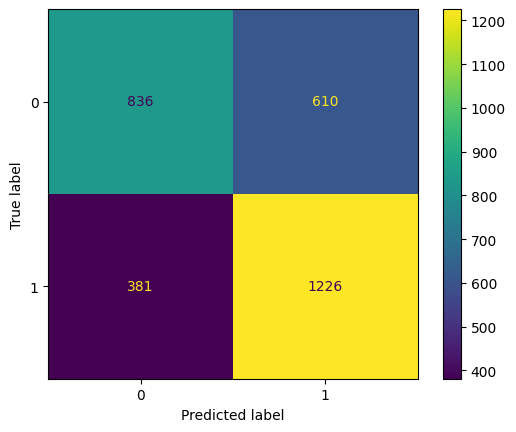

In [60]:
cm = confusion_matrix(y_test, rf_cv_preds, labels=rf_cv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf_cv.classes_)
disp.plot();

**Question:** What type of errors are more common for your model?

The model is almost twice as likely to predict a false positive than it is to predict a false negative. Therefore, type I errors are more common. This is less desirable, because it's better for a driver to be pleasantly surprised by a generous tip when they weren't expecting one than to be disappointed by a low tip when they were expecting a generous one. However, the overall performance of this model is satisfactory.

##### Feature importance

Using the `feature_importances_` attribute of the best estimator object to inspect the features of your final model. You can then sort them and plot the most important ones:

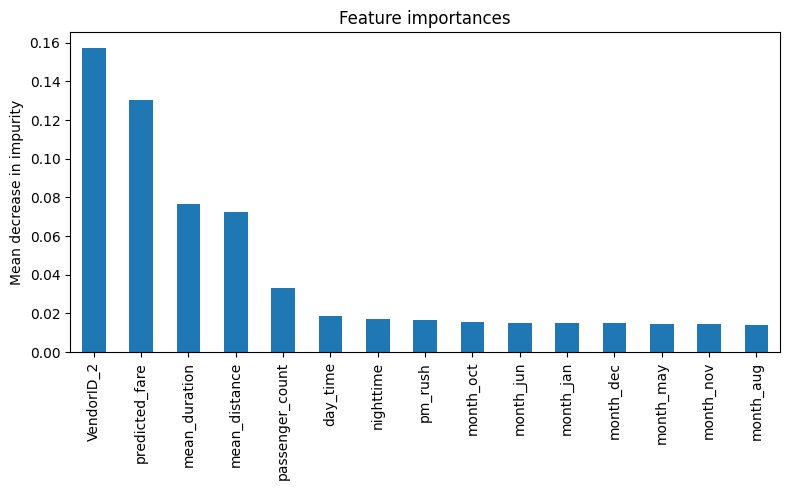

In [61]:
importances = rf_cv.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test.columns)
rf_importances = rf_importances.sort_values(ascending=False)[:15]

fig, ax = plt.subplots(figsize=(8,5))
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout();

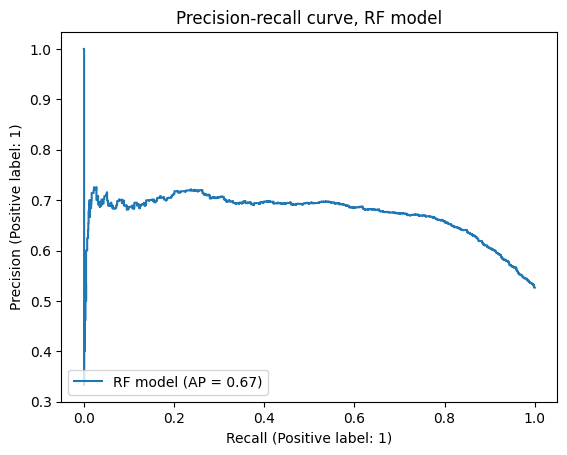

In [62]:
display = PrecisionRecallDisplay.from_estimator(
    rf_cv.best_estimator_, X_test, y_test, name='RF model'
    )
plt.title('Precision-recall curve, RF model');


## **PACE: Execute**



### **Task 4. Conclusion**

Consider the following questions:

1. **Would you recommend using this model? Why or why not?**  
Yes, this is model performs acceptably. Its F<sub>1</sub> score was 0.7235 and it had an overall accuracy of 0.6865. It correctly identified ~78% of the actual responders in the test set, which is 48% better than a random guess. It may be worthwhile to test the model with a select group of taxi drivers to get feedback.  


2. **What was your highest scoring model doing? Can you explain how it was making predictions?**   
Unfortunately, random forest is not the most transparent machine learning algorithm. We know that `VendorID`, `predicted_fare`, `mean_duration`, and `mean_distance` are the most important features, but we don't know how they influence tipping. This would require further exploration. It is interesting that `VendorID` is the most predictive feature. This seems to indicate that one of the two vendors tends to attract more generous customers. It may be worth performing statistical tests on the different vendors to examine this further.  


3. **Are there new features that you can engineer that might improve model performance?**  
There are almost always additional features that can be engineered, but hopefully the most obvious ones were generated during the first round of modeling. In our case, we could try creating three new columns that indicate if the trip distance is short, medium, or far. We could also engineer a column that gives a ratio that represents (the amount of money from the fare amount to the nearest higher multiple of \\$5) / fare amount. For example, if the fare were \\$12, the value in this column would be 0.25, because \\$12 to the nearest higher multiple of \\$5 (\\$15) is \\$3, and \\$3 divided by \\$12 is 0.25. The intuition for this feature is that people might be likely to simply round up their tip, so journeys with fares with values just under a multiple of \\$5 may have lower tip percentages than those with fare values just over a multiple of \\$5. We could also do the same thing for fares to the nearest \\$10.

$$
round5\_ratio = \frac{amount\ of\ money\ from\ the\ fare\ amount\ to\ the\ nearest\ higher\ multiple\ of\ \$5}{fare\ amount}
$$

<br>

<details>
    <summary><h5>HINT</h5></summary>
    $$ = \frac{5 - (fare\ mod\ 5)}{fare\ amount}$$
</details>

<br>

4. **What features would you want to have that would likely improve the performance of your model?**   
It would probably be very helpful to have past tipping behavior for each customer. It would also be valuable to have accurate tip values for customers who pay with cash.
It would be helpful to have a lot more data. With enough data, we could create a unique feature for each pickup/dropoff combination.


Remember, sometimes your data simply will not be predictive of your chosen target. This is common. Machine learning is a powerful tool, but it is not magic. If your data does not contain predictive signal, even the most complex algorithm will not be able to deliver consistent and accurate predictions. Do not be afraid to draw this conclusion. Even if you cannot use the model to make strong predictions, the work was not done in vain.